Analyze of framewise displacement distributions and selection of samples. 


Copyright: G. J.-P. C. Becq, Gipsa-lab, UMR 5216, CNRS  
Date: 2019-05-07

This software is governed by the CeCILL-B license under French law and
abiding by the rules of distribution of free software.  You can  use, 
modify and/ or redistribute the software under the terms of the CeCILL-B 
license as circulated by CEA, CNRS and INRIA at the following URL
"http://www.cecill.info". 

As a counterpart to the access to the source code and  rights to copy,
modify and redistribute granted by the license, users are provided only
with a limited warranty  and the software's author,  the holder of the
economic rights,  and the successive licensors  have only  limited
liability. 

In this respect, the user's attention is drawn to the risks associated
with loading,  using,  modifying and/or developing or reproducing the
software by the user in light of its specific status of free software,
that may mean  that it is complicated to manipulate,  and  that  also
therefore means  that it is reserved for developers  and  experienced
professionals having in-depth computer knowledge. Users are therefore
encouraged to load and test the software's suitability as regards their
requirements in conditions enabling the security of their systems and/or 
data to be ensured and,  more generally, to use and operate it in the 
same conditions as regards security. 

The fact that you are presently reading this means that you have had
knowledge of the CeCILL-B license and that you accept its terms.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import tools
import pandas as pd
import importlib as imp
imp.reload(tools)
import scipy.signal as signal
import os

In [7]:
pn = '../fig/'
if os.path.exists(pn):
    print(pn + ' already exists ')
else: 
    print(pn + ' does not exist')
    os.mkdir(pn)

../fig/ already exists 


In [8]:
df_db = pd.read_csv('../data/trial.csv')

In [9]:
a_fd = ones((df_db.shape[0], 3600))
for i in df_db.index: 
    print('.', end='')
    name = df_db.loc[i, 'NAME']
    (t, mx, hr, rr, temp, coreg) = tools.get_sig_mov(name)
    fd = tools.get_framewise_displacement(coreg)
    a_fd[i, :] = fd

......................................

In [10]:
print(np.amin(a_fd), np.amax(a_fd), np.mean(a_fd), np.std(a_fd))

0.0 4.553967963999999 0.03145908659197748 0.09156873169157095


In [11]:
a_fd_flat = a_fd.flatten()

In [12]:
#figure(figsize=(20, 8))
#matshow(a_fd, aspect=100, fignum=0)

In [13]:
th = 0.01
a_fd_th = zeros((a_fd.shape[0], 9, 3600))
for i in range(a_fd.shape[0]): 
    m1 = mean(a_fd[i, :])
    s1 = std(a_fd[i, :])
    print(i, s1 / m1)

0 0.42926967605332533
1 0.36839617324501067
2 1.6004280273361624
3 0.5879575265730798
4 0.39656221988267404
5 0.6059799139791564
6 0.46398122289858823
7 0.565637216062405
8 0.3745206139454914
9 0.5291035648122431
10 0.43897696013002935
11 0.3650731839482504
12 0.5160925526537978
13 0.3860299780576968
14 0.8965338648460232
15 0.4970734607075444
16 0.33627488211744416
17 0.3915867120174709
18 0.46714112903051197
19 1.3652625362146436
20 0.8294595389081164
21 0.5737939608831288
22 0.4836776393246946
23 0.35232390461012375
24 0.33705978084918514
25 0.35977609520303333
26 1.640263814494133
27 0.4380275694024927
28 0.44760557946052065
29 0.3644179666416613
30 0.28038972646196403
31 0.3825309931383638
32 0.4035875198574096
33 0.3934082450645031
34 0.36765018285386675
35 0.34557341054900687
36 0.7630890507697722
37 0.4004830225867177


In [14]:
imp.reload(tools)
#th = 0.46 / 10
th = 0.1
a_fd_th = zeros((a_fd.shape[0], 9, 3600))
for i in range(a_fd.shape[0]): 
    print('.', end='')
    a_fd_th[i, :, :] = tools.get_df_select_no_mvt(a_fd[i, :], th)

.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


.....................................

In [15]:
def get_QC_FC(fd, x, th): 
    """
    x is n_obs by n_d
    fd is n_obs
    th is int. 
    
    >>> x = array([[1, 2, 3, 4], [4, 3, 2, 1]])

    """
    (n_d, n_obs) = x.shape
    x_cond = zeros((3600, ))
    x_cond[0] = 1
    x_cond[-1] = 1
    cond_fd_th = (fd >= th) # movement
    x_cond[cond_fd_th] = 1 
    x_cond = signal.lfilter(ones((40, )), 40, x_cond)
    x_cond = signal.filtfilt(ones((57, )), 57, x_cond)
    x_no_mvt = (x_cond == 0)
    fd_ret = fd[x_no_mvt]
    n_over_th = sum(x_no_mvt)
    x_ret = zeros((n_d, n_over_th))
    for i in range(n_d): 
        x_ret[i, :] = x[i, x_no_mvt]
    C = corrcoef(x_ret)
    c_1 = tools.get_flat_upper_c(C)
    m_fd = np.mean(fd_ret)
    m_c = np.mean(c_1)
    return (m_fd, m_c, n_over_th)

def get_QC_FC_n(fd, x, n=10):
    fd_max = np.amax(fd)
    fd_min = np.amin(fd)
    step = (fd_max - fd_min) / n
    l_th = arange(fd_min + step, fd_max + 0.9 * step, step)
    a_m_fd = zeros((n))
    a_m_fc = zeros((n))
    a_n = zeros((n))
    for (i, th) in enumerate(l_th): 
        (a_m_fd[i], a_m_fc[i], a_n[i]) = get_QC_FC(fd, x, th)
    return (l_th, a_m_fd, a_m_fc, a_n)

In [16]:
print(3600 / 2**4 - 6)
print(3495 / 2 ** 4)

219.0
218.4375


In [17]:
rec_1 = tools.Record(df_db, 0)
n = rec_1.x4.shape[1]
pad = int((3600 - n) / 2)
fmri_x = np.zeros((51, 3600))
fmri_x[:, pad + 1: -pad] = rec_1.x4 
(m_fd, m_c, n_over_th) = get_QC_FC(rec_1.fd, fmri_x, 0.01)
print((m_fd, m_c, n_over_th))

(nan, nan, 0)


0.04216073375252257 0.20499278253671216 0


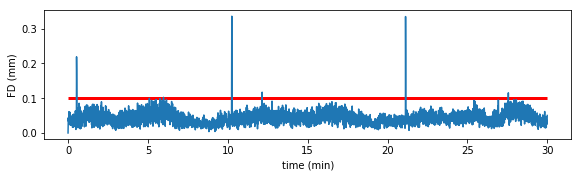

In [18]:
th=0.1
x = fmri_x
fd = rec_1.fd
figure(figsize=(24/2.54, 6/2.54))
plot(fd)
(n_d, n_obs) = x.shape
x_cond = zeros((3600, ))
x_cond[0] = 1
cond_fd_th = (fd >= th) # movement
x_cond[cond_fd_th] = 1 
#plot(x_cond)
x_cond = signal.lfilter(ones((40, )), 40, x_cond)
#plot(x_cond + 1)
x_cond = signal.filtfilt(ones((57, )), 57, x_cond) # at cD4
#plot(x_cond  + 2)
x_no_mvt = (x_cond == 0)
#plot(x_no_mvt + 3)
fd_ret = fd[x_no_mvt]

n_no_mvt = sum(x_no_mvt)
x_ret = zeros((n_d, n_no_mvt))
for i in range(n_d): 
    x_ret[i, :] = x[i, x_no_mvt]
#    if i == 3: 
#        plot(x[i, :])
#        plot(x_ret[i, :]+1)
    
C = corrcoef(x_ret)
c_1 = tools.get_flat_upper_c(C)
m_fd = np.mean(fd_ret)
m_c = np.mean(c_1)
print(m_fd, m_c, n_over_th)
xticks(arange(0, 3601, 600), arange(0, 31, 5))
ylabel('FD (mm)')
xlabel('time (min)')
hlines(0.1, 0, 3600, colors='r', linewidth=3)
tools.mysavefig('../fig/no_mvt_fd_0')

......................................

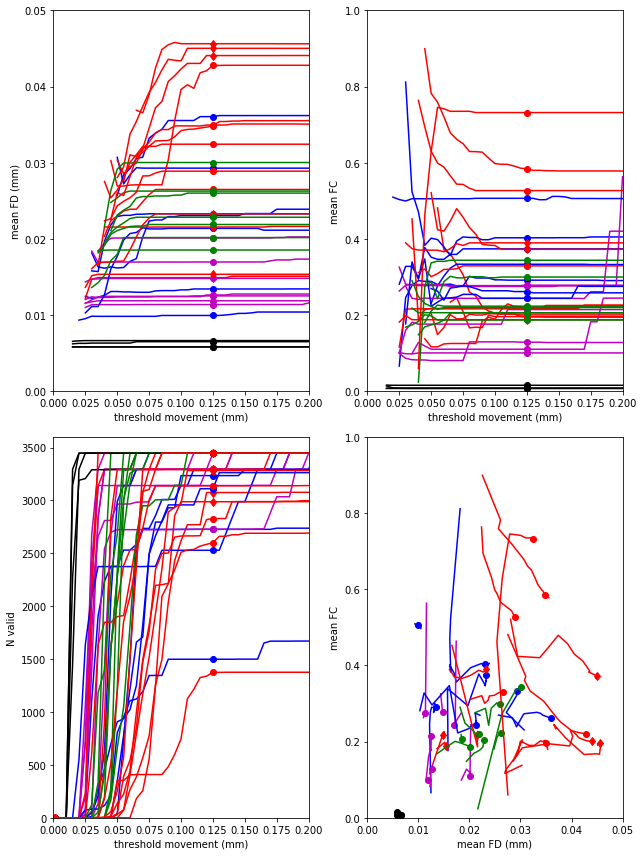

In [14]:
l_th = arange(0, 0.25, 0.005)
l_th[0] = 0.001
n_th = len(l_th)
a_m_fd = zeros((n_th))
a_m_fc = zeros((n_th))
a_n = zeros((n_th))
(fig, ax) = subplots(2, 2, figsize=(9, 12))
for i in df_db.index: 
    print('.', end="")
    rec_1 = tools.Record(df_db, i)
    n = rec_1.x4.shape[1]
    pad = int((3600 - n) / 2)
    fmri_x = np.zeros((51, 3600))
    fmri_x[:, pad + 1: -pad] = rec_1.x4 
    for (j, th) in enumerate(l_th): 
        (a_m_fd[j], a_m_fc[j], a_n[j]) = get_QC_FC(rec_1.fd, fmri_x, th)
    #(l_th, a_m_fd, a_m_fc, a_n) = get_QC_FC_n(rec_1.fd, fmri_x, n=20)
    """
    subplot(1, 4, 1)
    plot(l_th, a_m_fd, '.-')
    xlabel('th (mm)')
    ylabel('mean FD (mm)')
    title(rec_1.name)
    subplot(1, 4, 2)
    plot(l_th, a_m_fc, '.-')
    xlabel('th (mm)')
    ylabel('mean FC')
    title(rec_1.group)
    subplot(1, 4, 3)
    plot(l_th, a_n, '.-')
    xlabel('th (mm)')
    ylabel('n')
    title(rec_1.name)
    subplot(1, 4, 4)
    plot(a_m_fd, a_m_fc, '.-')
    xlabel('mean FD (mm)')
    ylabel('mean FC')
    title(rec_1.name)

    tight_layout()
    """
    i_group = tools.L_GROUP.index(rec_1.group)
    color_i = tools.L_GROUP_COLOR[i_group]
    marker_i = tools.L_GROUP_MARKER[i_group]
    ax[0][0].plot(l_th, a_m_fd, '.-', color=color_i, marker=marker_i, markevery=25);
    ax[0][1].plot(l_th, a_m_fc, '.-', color=color_i, marker=marker_i, markevery=25);
    ax[1][0].plot(l_th, a_n, '.-', color=color_i, marker=marker_i, markevery=25);
    ax[1][1].plot(a_m_fd, a_m_fc, '.-', color=color_i, marker=marker_i, markevery=25);
ax[0][0].axis([0, 0.2, 0, 0.05]);
ax[0][0].set_xlabel('threshold movement (mm)');
ax[0][0].set_ylabel('mean FD (mm)');

ax[0][1].axis([0, 0.2, 0, 1]);
ax[0][1].set_xlabel('threshold movement (mm)');
ax[0][1].set_ylabel('mean FC');

ax[1][0].axis([0, 0.2, 0, 3600]);
ax[1][0].set_xlabel('threshold movement (mm)');
ax[1][0].set_ylabel('N valid');

ax[1][1].axis([0, 0.05, 0, 1]);
ax[1][1].set_xlabel('mean FD (mm)');
ax[1][1].set_ylabel('mean FC');

tight_layout()

......................................

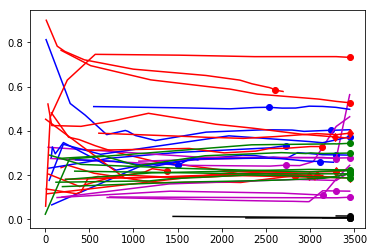

In [15]:
for i in df_db.index: 
    print('.', end="")
    rec_1 = tools.Record(df_db, i)
    n = rec_1.x4.shape[1]
    pad = int((3600 - n) / 2)
    fmri_x = np.zeros((51, 3600))
    fmri_x[:, pad + 1: -pad] = rec_1.x4 
    for (j, th) in enumerate(l_th): 
        (a_m_fd[j], a_m_fc[j], a_n[j]) = get_QC_FC(rec_1.fd, fmri_x, th)
    i_group = tools.L_GROUP.index(rec_1.group)
    color_i = tools.L_GROUP_COLOR[i_group]
    marker_i = tools.L_GROUP_MARKER[i_group]
    plot(a_n, a_m_fc, '.-', color=color_i, marker=marker_i, markevery=25);


In [19]:
a_fd_flat_h = a_fd_flat.copy()
a_fd_flat_h[a_fd_flat_h >= 0.2] = 0.2
res = histogram(a_fd_flat_h, bins=100, range=(0, 0.2)); 

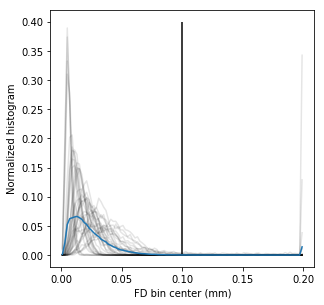

In [20]:
(fig, ax1) = subplots(1, figsize=(12/2.54, 12/2.54))
a_hist = zeros((a_fd.shape[0], 100))
for i in range(a_fd.shape[0]): 
    a_fd_h = a_fd[i, :].copy()
    a_fd_h[a_fd_h >= 0.2] = 0.2
    res_i = histogram(a_fd_h, bins=100, range=(0, 0.2)); 
    a_hist[i, :] = res_i[0]
    ax1.plot((res_i[1][:-1] + res_i[1][1:])/2, res_i[0] / sum(res_i[0]), 'k', alpha=0.1)
ax1.plot((res[1][:-1] + res[1][1:])/2, res[0] / sum(res[0]))
ax1.vlines(0.1, 0, 0.4)
ax1.set_ylabel('Normalized histogram')
ax1.set_xlabel('FD bin center (mm)')
#ax1.set_title('a)')
tools.mysavefig('../fig/no_mvt_fd_hist')

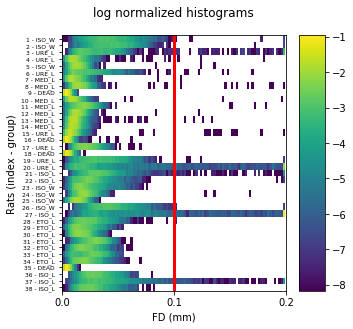

In [28]:
fig, ax1 = subplots(1, figsize=(12/2.54, 12/2.54))
m1 = ax1.matshow(log(a_hist / 3600), aspect=3)
ax1.set_xticks(arange(0, 100.1, 50))
ax1.set_xticklabels(arange(0, 0.201, 0.1))
l_rat = [str(i + 1) + ' - ' + g_i for (i, g_i) in zip(arange(38), df_db['GROUP'])]
ax1.set_yticks(arange(38))
ax1.set_yticklabels(l_rat, fontsize=6); 
ax1.set_ylabel('Rats (index - group)')
ax1.set_xlabel('FD (mm)')
ax1.set_title('log normalized histograms')
ax1.xaxis.set_ticks_position('bottom')
ax1.vlines(100/0.2*0.1, -1, 38, 'r', linewidth=3)
ax1.axis([0, 100, 37.5, -0.5])
cb = colorbar(mappable=m1, ax=ax1, aspect=10, fraction=0.1)
#cb.set_ticklabels(['0.1', '0.1 mm', '0.47 mm'])
tools.mysavefig('../fig/no_mvt_fd_all_hist')

In [23]:
log(0.47)

-0.7550225842780328

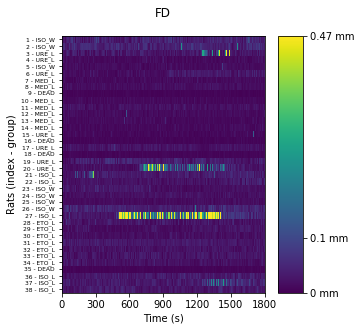

In [24]:
fig, ax1 = subplots(1, figsize=(12/2.54, 12/2.54))
#m1 = ax1.matshow(log(a_fd), aspect=120, vmin=-4, vmax=1)
m1 = ax1.matshow(a_fd, aspect=120, vmin=0, vmax=0.47)
#ax1.set_xticks(arange(0, 100.1, 50))
#ax1.set_xticklabels(arange(0, 0.201, 0.1))
l_rat = [str(i + 1) + ' - ' + g_i for (i, g_i) in zip(arange(38), df_db['GROUP'])]
ax1.set_yticks(arange(38))
ax1.set_yticklabels(l_rat, fontsize=6); 
ax1.set_ylabel('Rats (index - group)')
ax1.set_xlabel('Time (s)')
ax1.set_xticks(arange(0, 3601, 600))
ax1.set_xticklabels(arange(0, 1801, 300))
ax1.set_title('FD')
ax1.xaxis.set_ticks_position('bottom')
#cb = colorbar(mappable=m1, ax=ax1, aspect=10, fraction=0.1, ticks=[-4, -3, -2, -1, -0.76, 0, 1])
#cb.set_ticklabels(['0.1 um', '1 um', '0.01 mm', '0.1 mm', '0.47 mm', '1 mm', '10 mm'])
cb = colorbar(mappable=m1, ax=ax1, aspect=10, fraction=0.1, ticks=[0, 0.1, 0.47])
cb.set_ticklabels(['0 mm', '0.1 mm', '0.47 mm'])
tools.mysavefig('../fig/no_mvt_fd_all')

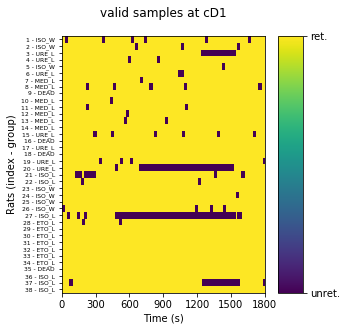

In [25]:
fig, ax1 = subplots(1, figsize=(12/2.54, 12/2.54))
m1 = ax1.matshow(a_fd_th[:, 1, :], aspect=120, vmin=0, vmax=1)
#ax1.set_xticks(arange(0, 100.1, 50))
#ax1.set_xticklabels(arange(0, 0.201, 0.1))
l_rat = [str(i + 1) + ' - ' + g_i for (i, g_i) in zip(arange(38), df_db['GROUP'])]
ax1.set_yticks(arange(38))
ax1.set_yticklabels(l_rat, fontsize=6); 
ax1.set_ylabel('Rats (index - group)')
ax1.set_xlabel('Time (s)')
ax1.set_xticks(arange(0, 3601, 600))
ax1.set_xticklabels(arange(0, 1801, 300))
ax1.set_title('valid samples at cD1')
ax1.xaxis.set_ticks_position('bottom')
cb = colorbar(mappable=m1, ax=ax1, aspect=10, fraction=0.1, ticks=[0, 1])
cb.set_ticklabels(['unret.', 'ret.'])
tools.mysavefig('../fig/no_mvt_fd_valid_cD1')

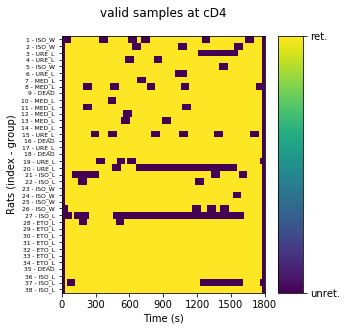

In [26]:
fig, ax1 = subplots(1, figsize=(12/2.54, 12/2.54))
m1 = ax1.matshow(a_fd_th[:, 4, :], aspect=120, vmin=0, vmax=1)
#ax1.set_xticks(arange(0, 100.1, 50))
#ax1.set_xticklabels(arange(0, 0.201, 0.1))
l_rat = [str(i + 1) + ' - ' + g_i for (i, g_i) in zip(arange(38), df_db['GROUP'])]
ax1.set_yticks(arange(38))
ax1.set_yticklabels(l_rat, fontsize=6); 
ax1.set_ylabel('Rats (index - group)')
ax1.set_xlabel('Time (s)')
ax1.set_xticks(arange(0, 3601, 600))
ax1.set_xticklabels(arange(0, 1801, 300))
ax1.set_title('valid samples at cD4')
ax1.xaxis.set_ticks_position('bottom')
cb = colorbar(mappable=m1, ax=ax1, aspect=10, fraction=0.1, ticks=[0, 1])
cb.set_ticklabels(['unret.', 'ret.'])
tools.mysavefig('../fig/no_mvt_fd_valid_cD4')

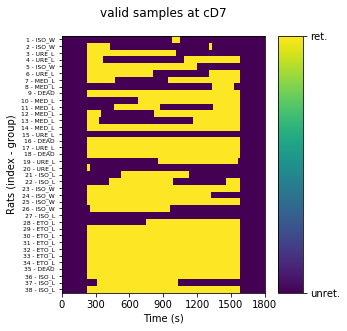

In [27]:
fig, ax1 = subplots(1, figsize=(12/2.54, 12/2.54))
m1 = ax1.matshow(a_fd_th[:, 7, :], aspect=120, vmin=0, vmax=1)
#ax1.set_xticks(arange(0, 100.1, 50))
#ax1.set_xticklabels(arange(0, 0.201, 0.1))
l_rat = [str(i + 1) + ' - ' + g_i for (i, g_i) in zip(arange(38), df_db['GROUP'])]
ax1.set_yticks(arange(38))
ax1.set_yticklabels(l_rat, fontsize=6); 
ax1.set_ylabel('Rats (index - group)')
ax1.set_xlabel('Time (s)')
ax1.set_xticks(arange(0, 3601, 600))
ax1.set_xticklabels(arange(0, 1801, 300))
ax1.set_title('valid samples at cD7')
ax1.xaxis.set_ticks_position('bottom')
cb = colorbar(mappable=m1, ax=ax1, aspect=10, fraction=0.1, ticks=[0, 1])
cb.set_ticklabels(['unret.', 'ret.'])
tools.mysavefig('../fig/no_mvt_fd_valid_cD7')

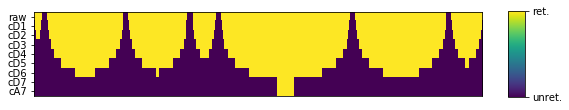

In [128]:
fig, ax1 = subplots(1, figsize=(24/2.54, 4/2.54))
m1 = ax1.matshow(a_fd_th[0, :, :], aspect=75)
#xlabel('time (min)')
ax1.set_xticks([])#arange(0, 3601, 600), arange(0, 31, 5))
ax1.set_yticks(arange(0, 9))
ax1.set_yticklabels(['raw'] + tools.L_SCALE)
cb = colorbar(mappable=m1, ax=ax1, aspect=5, fraction=0.1, ticks=[0, 1])
cb.set_ticklabels(['unret.', 'ret.'])
#colorbar(mappable=m1, ax=ax1, aspect=10, fraction=0.1, ticks=[0, 1])
tools.mysavefig('../fig/no_mvt_fd_valid_0')

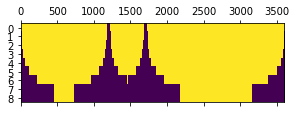

In [74]:
fig, ax1 = subplots(1, figsize=(12/2.54, 12/2.54))
m1 = ax1.matshow(a_fd_th[3, :, :], aspect=120, vmin=0, vmax=1)
tools.mysavefig('../fig/no_mvt_fd_valid_one_animal')

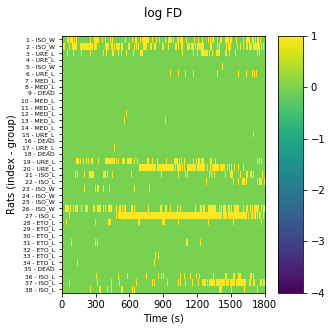

In [74]:
fig, ax1 = subplots(1, figsize=(12/2.54, 12/2.54))
m1 = ax1.matshow(a_fd > 0.047, aspect=120, vmin=-4, vmax=1)
#ax1.set_xticks(arange(0, 100.1, 50))
#ax1.set_xticklabels(arange(0, 0.201, 0.1))
l_rat = [str(i + 1) + ' - ' + g_i for (i, g_i) in zip(arange(38), df_db['GROUP'])]
ax1.set_yticks(arange(38))
ax1.set_yticklabels(l_rat, fontsize=6); 
ax1.set_ylabel('Rats (index - group)')
ax1.set_xlabel('Time (s)')
ax1.set_xticks(arange(0, 3601, 600))
ax1.set_xticklabels(arange(0, 1801, 300))
ax1.set_title('log FD')
ax1.xaxis.set_ticks_position('bottom')
colorbar(mappable=m1, ax=ax1, aspect=10, fraction=0.1, ticks=[-4, -3, -2, -1, 0, 1])
#tools.mysavefig('../fig/no_mvt_fd_all')

In [75]:
a_th = (a_fd > 0.1)

In [76]:
a_n_th = zeros((38, 200))
for (i, th) in enumerate(arange(0, 2, 0.01)): 
    a_th = (a_fd > th)
    a_n_th[:, i] = sum(a_th, 1)

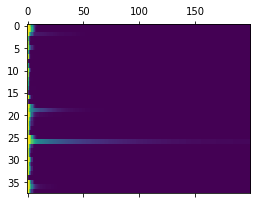

In [77]:
matshow(a_n_th, aspect=4)

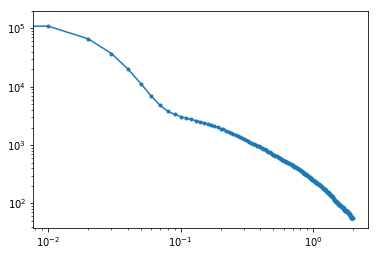

In [78]:
loglog(arange(0, 2, 0.01), sum(a_n_th, 0), '.-')
